In [1]:
# =====================================================
# MAXIMUM TensorFlow Log Suppression (BEST POSSIBLE)
# =====================================================
import os
import warnings

# Silence Python warnings
warnings.filterwarnings("ignore")

# Silence TensorFlow C++ logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # ERROR only

# Disable oneDNN logs
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Optional: limit visible GPUs (reduces CUDA spam)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.AUTOTUNE



E0000 00:00:1767158232.429786      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767158232.486348      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767158232.947108      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767158232.947147      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767158232.947150      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767158232.947152      55 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100
DATASET_DIR = "/kaggle/input/task-segmentation/Task - Segmentation"


In [4]:
def apply_clahe(img):
    img_u8 = (img * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img_u8)
    return img.astype(np.float32) / 255.0

def gaussian_smooth(img):
    return cv2.GaussianBlur(img, (3,3), 0)

def unsharp_mask(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    sharp = cv2.addWeighted(img, 1.2, blur, -0.2, 0)
    return np.clip(sharp, 0, 1)


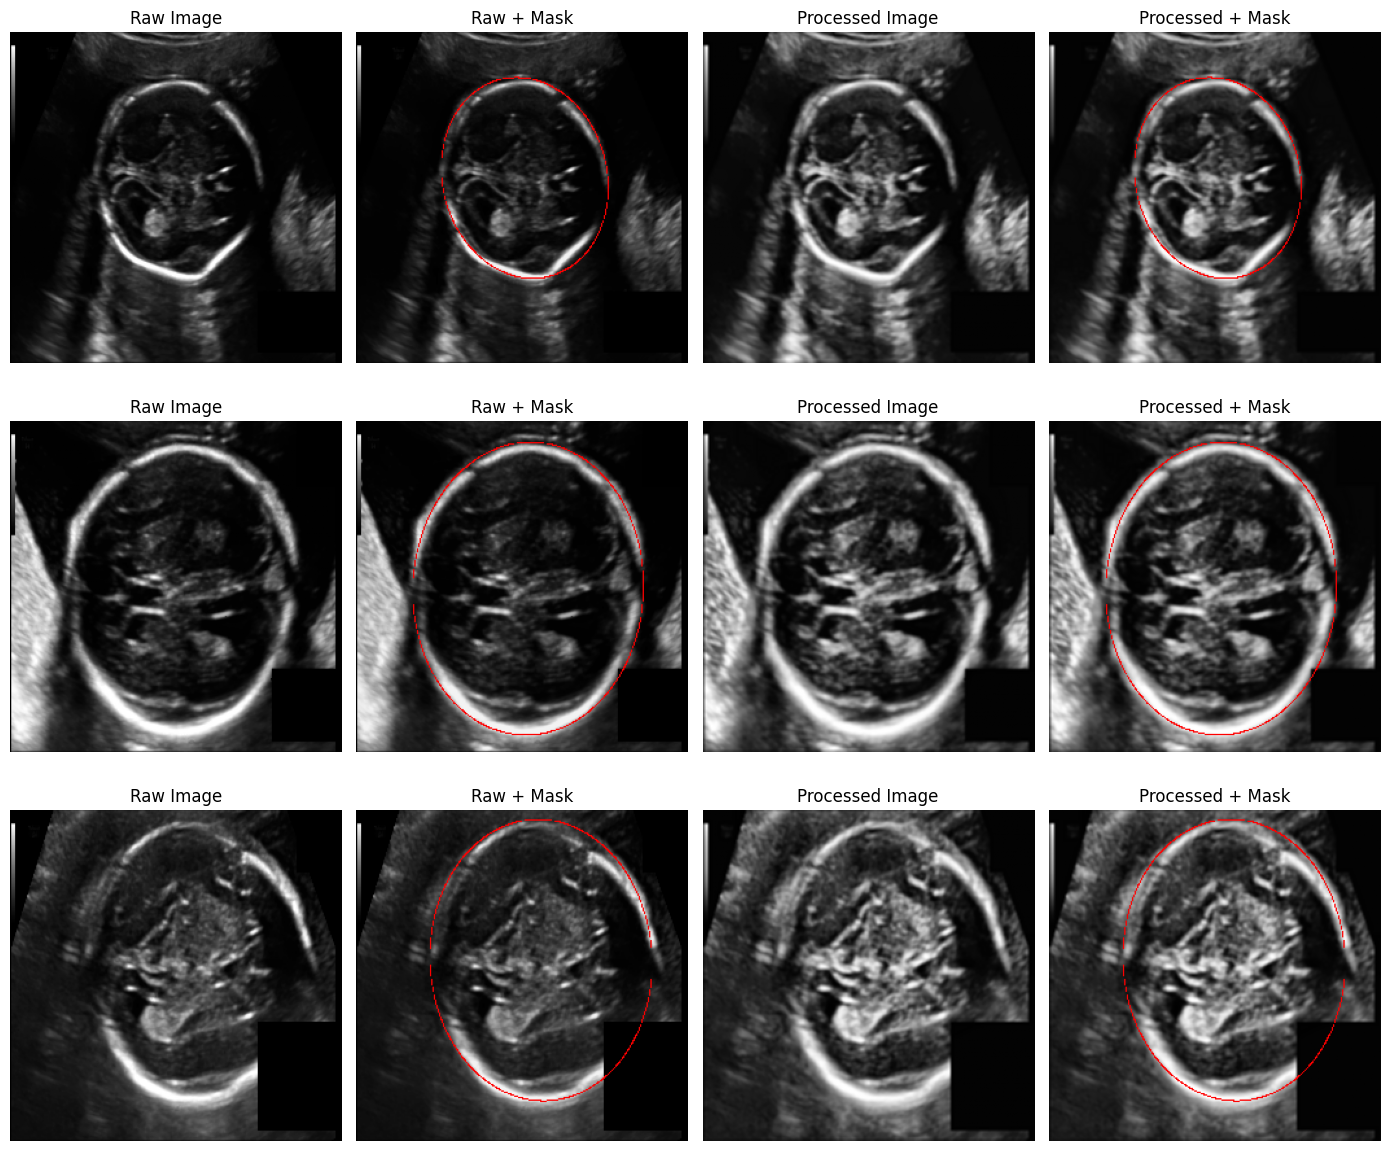

In [5]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

def visualize_preprocessing(dataset_dir, num_samples=3):
    img_dir = os.path.join(dataset_dir, "images")
    mask_dir = os.path.join(dataset_dir, "masks")

    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    samples = random.sample(img_files, num_samples)

    plt.figure(figsize=(14, 4 * num_samples))

    for i, img_file in enumerate(samples):
        img_id = img_file.split(".")[0]
        mask_file = [m for m in mask_files if img_id in m][0]

        # Load
        img = cv2.imread(os.path.join(img_dir, img_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, IMAGE_SIZE)
        mask = cv2.resize(mask, IMAGE_SIZE)

        # Raw image (green channel)
        raw = img[:, :, 1].astype(np.float32) / 255.0
        mask_bin = (mask > 127).astype(np.uint8)

        # Apply SAME processing as training
        proc = apply_clahe(raw)
        proc = gaussian_smooth(proc)
        proc = unsharp_mask(proc)

        # Overlays
        raw_overlay = np.stack([raw, raw, raw], axis=-1)
        raw_overlay[mask_bin > 0] = [1, 0, 0]

        proc_overlay = np.stack([proc, proc, proc], axis=-1)
        proc_overlay[mask_bin > 0] = [1, 0, 0]

        # Plot
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(raw, cmap="gray")
        plt.title("Raw Image")
        plt.axis("off")

        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(raw_overlay)
        plt.title("Raw + Mask")
        plt.axis("off")

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(proc, cmap="gray")
        plt.title("Processed Image")
        plt.axis("off")

        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(proc_overlay)
        plt.title("Processed + Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_preprocessing(DATASET_DIR, num_samples=3)


In [6]:
def thicken_mask(mask, thickness=3):
    kernel = np.ones((thickness, thickness), np.uint8)
    return cv2.dilate(mask, kernel)


In [7]:
def load_dataset(dataset_dir):
    images, masks = [], []

    img_dir = os.path.join(dataset_dir, "images")
    mask_dir = os.path.join(dataset_dir, "masks")

    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file in img_files:
        img_id = img_file.split(".")[0]
        match = [m for m in mask_files if img_id in m]
        if not match:
            continue

        img = cv2.imread(os.path.join(img_dir, img_file))
        mask = cv2.imread(os.path.join(mask_dir, match[0]), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, IMAGE_SIZE)
        mask = cv2.resize(mask, IMAGE_SIZE)

        # Green channel
        img = img[:, :, 1].astype(np.float32) / 255.0

        # Image processing pipeline
        img = apply_clahe(img)
        img = gaussian_smooth(img)
        img = unsharp_mask(img)

        # Mask processing
        mask = (mask > 127).astype(np.uint8)
        mask = thicken_mask(mask, thickness=3)

        images.append(img[..., np.newaxis])
        masks.append(mask[..., np.newaxis])

    return np.array(images, np.float32), np.array(masks, np.float32)


In [8]:
images, masks = load_dataset(DATASET_DIR)

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)


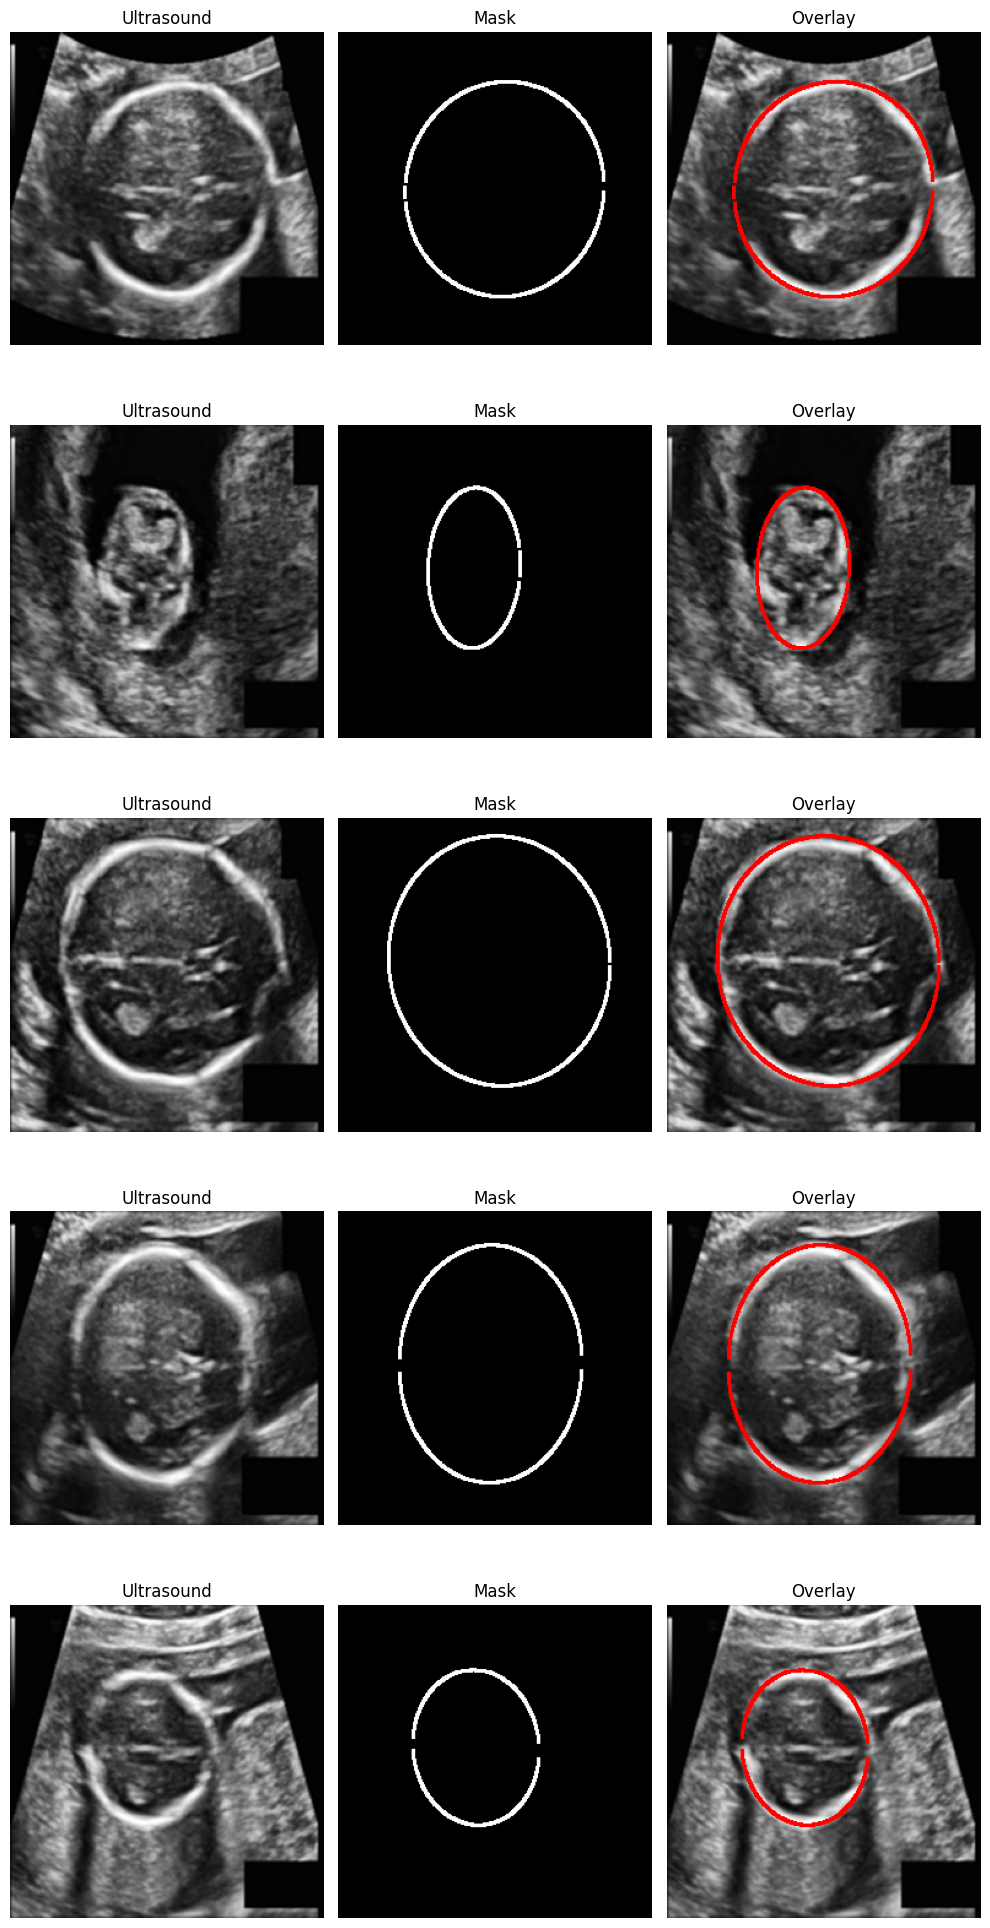

In [9]:
def visualize_raw_samples(images, masks, num_samples=5):
    idxs = random.sample(range(len(images)), num_samples)
    plt.figure(figsize=(10, 4*num_samples))

    for i, idx in enumerate(idxs):
        img = images[idx].squeeze()
        mask = masks[idx].squeeze()

        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img, cmap="gray")
        plt.title("Ultrasound")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        overlay = np.stack([img, img, img], axis=-1)
        overlay[mask > 0] = [1, 0, 0]

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_raw_samples(images, masks)


In [10]:
def augment(img, mask):
    # Intensity variations
    img = tf.image.random_contrast(img, 0.95, 1.05)
    img = tf.image.random_brightness(img, 0.05)

    # Horizontal flip ONLY
    flip = tf.random.uniform([]) > 0.5
    img = tf.cond(flip, lambda: tf.image.flip_left_right(img), lambda: img)
    mask = tf.cond(flip, lambda: tf.image.flip_left_right(mask), lambda: mask)

    # Very light noise
    noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.01)
    img = tf.clip_by_value(img + noise, 0.0, 1.0)

    return img, mask


In [11]:
def make_dataset(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(256)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val, y_val)
test_ds  = make_dataset(X_test, y_test)


I0000 00:00:1767158267.004184      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
# mUnet Model from the script
def mUnet_model(input_shape=(256, 256, 1)):
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = input_shape
    
    # Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = layers.Dropout(0.2)(c1)
    c1 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.2)(c2)
    c2 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


    #Expansive path
    u6 = layers.Conv2DTranspose(600, (2, 2), strides=(2, 2), padding='same')(c5)
    m1 = layers.MaxPooling2D((8, 8))(c1)
    l1 = layers.concatenate([u6, m1])
    u6 = layers.concatenate([l1, c4])
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(600, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


    u7 = layers.Conv2DTranspose(300, (2, 2), strides=(2, 2), padding='same')(c6)
    m2 = layers.MaxPooling2D((4, 4))(c1)
    l2 = layers.concatenate([u7, m2])
    u7 = layers.concatenate([l2, c3])
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(300, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(150, (2, 2), strides=(2, 2), padding='same')(c7)
    m3 = layers.MaxPooling2D((2, 2))(c1)
    l3 = layers.concatenate([u8, m3])
    u8 = layers.concatenate([l3, c2])
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.2)(c8)
    c8 = layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


    u9 = layers.Conv2DTranspose(75, (2, 2), strides=(2, 2), padding='same')(c8)
    l4 = layers.concatenate([u9, c1])
    u9 = layers.concatenate([l4, c1], axis=3)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.2)(c9)
    c9 = layers.Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

In [13]:
def focal_tversky(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)

    tversky = (tp + 1e-6) / (tp + alpha*fn + beta*fp + 1e-6)
    return tf.pow(1 - tversky, gamma)

def dice(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return (2*tf.reduce_sum(y_true*y_pred)+1e-6) / (
            tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+1e-6)


In [14]:
model = mUnet_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_tversky,
    metrics=[dice]
)

model.summary()


cb = [
    callbacks.EarlyStopping(
        monitor="val_dice",
        mode="max",
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_dice",
        mode="max",
        factor=0.5,
        patience=3
    ),
    callbacks.ModelCheckpoint(
        "best_hc_contour_model.keras",
        monitor="val_dice",
        mode="max",
        save_best_only=True
    )
]



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        750 │ input_layer[0][0] │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     50,700 │ dropout[0][0]     │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │    101,400 │ max_pooling2d[0]… │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    202,650 │ dropout_1[0][0]   │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    405,300 │ max_pooling2d_1[… │
│                     │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    810,300 │ dropout_2[0][0]   │
│                     │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,620,600 │ max_pooling2d_2[… │
│                     │ 600)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 600)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  3,240,600 │ dropout_3[0][0]   │
│                     │ 600)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 43,371,901 (165.45 MB)

 Trainable params: 43,371,901 (165.45 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb
)


Epoch 1/100


I0000 00:00:1767158275.399549     126 service.cc:152] XLA service 0x7aa258002e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767158275.399587     126 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767158276.629985     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767158331.347955     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - dice: 0.0852 - loss: 0.9049 - val_dice: 0.1231 - val_loss: 0.8567 - learning_rate: 1.0000e-04
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - dice: 0.2708 - loss: 0.7388 - val_dice: 0.2762 - val_loss: 0.7069 - learning_rate: 1.0000e-04
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - dice: 0.3697 - loss: 0.6417 - val_dice: 0.3248 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 425ms/step - dice: 0.4358 - loss: 0.5803 - val_dice: 0.3879 - val_loss: 0.6077 - learning_rate: 1.0000e-04
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - dice: 0.4544 - loss: 0.5635 - val_dice: 0.4718 - val_loss: 0.5499 - learning_rate: 1.0000e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - dice: 0.4862 - loss: 0.5350 - val_dice: 0.4633 - val_loss: 0.5462 - learning_rate: 1.0000e-04
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - dice: 0.5001 - loss: 0.5191 - val_dice: 0.4701 - val_loss:

In [16]:
model.evaluate(test_ds)
model.save("hc_contour_final.keras")


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - dice: 0.5655 - loss: 0.4713


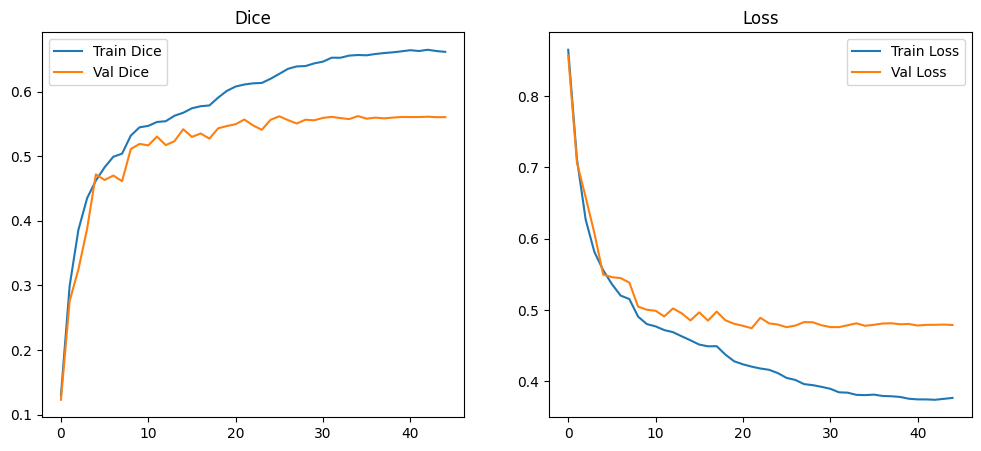

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["dice"], label="Train Dice")
plt.plot(history.history["val_dice"], label="Val Dice")
plt.legend()
plt.title("Dice")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


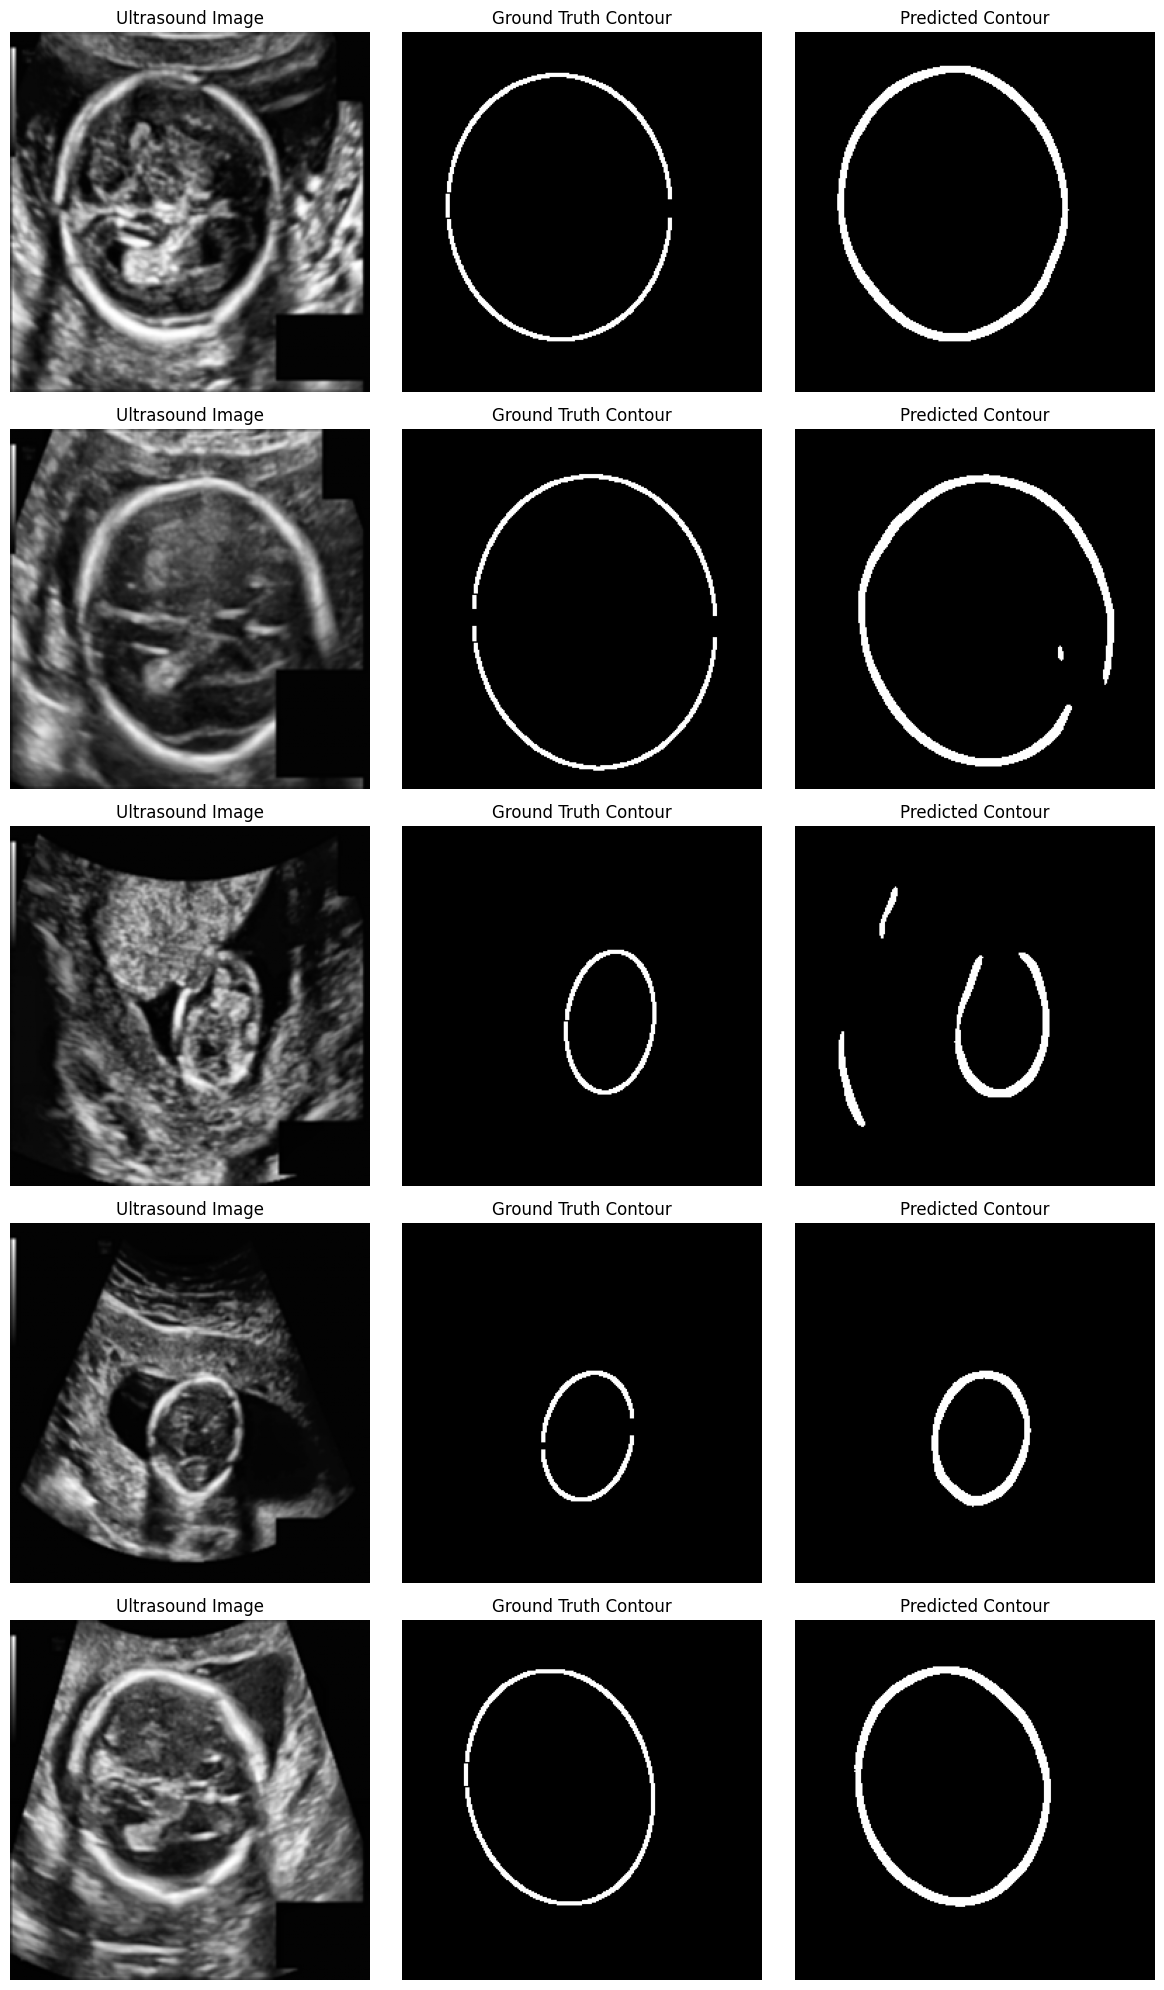

In [18]:
import random

def visualize_predictions(model, dataset, num_samples=5):
    samples = []
    for img, mask in dataset.unbatch():
        samples.append((img.numpy(), mask.numpy()))
    selected = random.sample(samples, num_samples)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, (img, gt) in enumerate(selected):
        pred = model.predict(img[np.newaxis, ...], verbose=0)[0]
        pred_bin = (pred > 0.5).astype(np.uint8)

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title("Ultrasound Image")
        plt.axis("off")

        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(gt.squeeze(), cmap="gray")
        plt.title("Ground Truth Contour")
        plt.axis("off")

        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_bin.squeeze(), cmap="gray")
        plt.title("Predicted Contour")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_ds, num_samples=5)

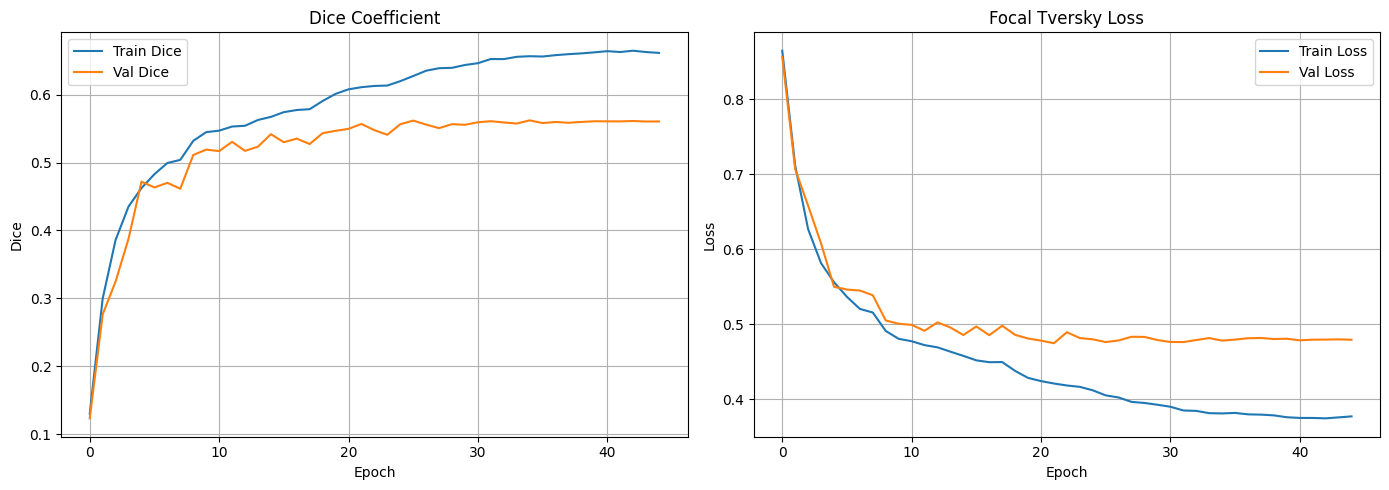

In [19]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14,5))

    # Dice
    plt.subplot(1,2,1)
    plt.plot(history.history["dice"], label="Train Dice")
    plt.plot(history.history["val_dice"], label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Dice Coefficient")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Focal Tversky Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 30s/step


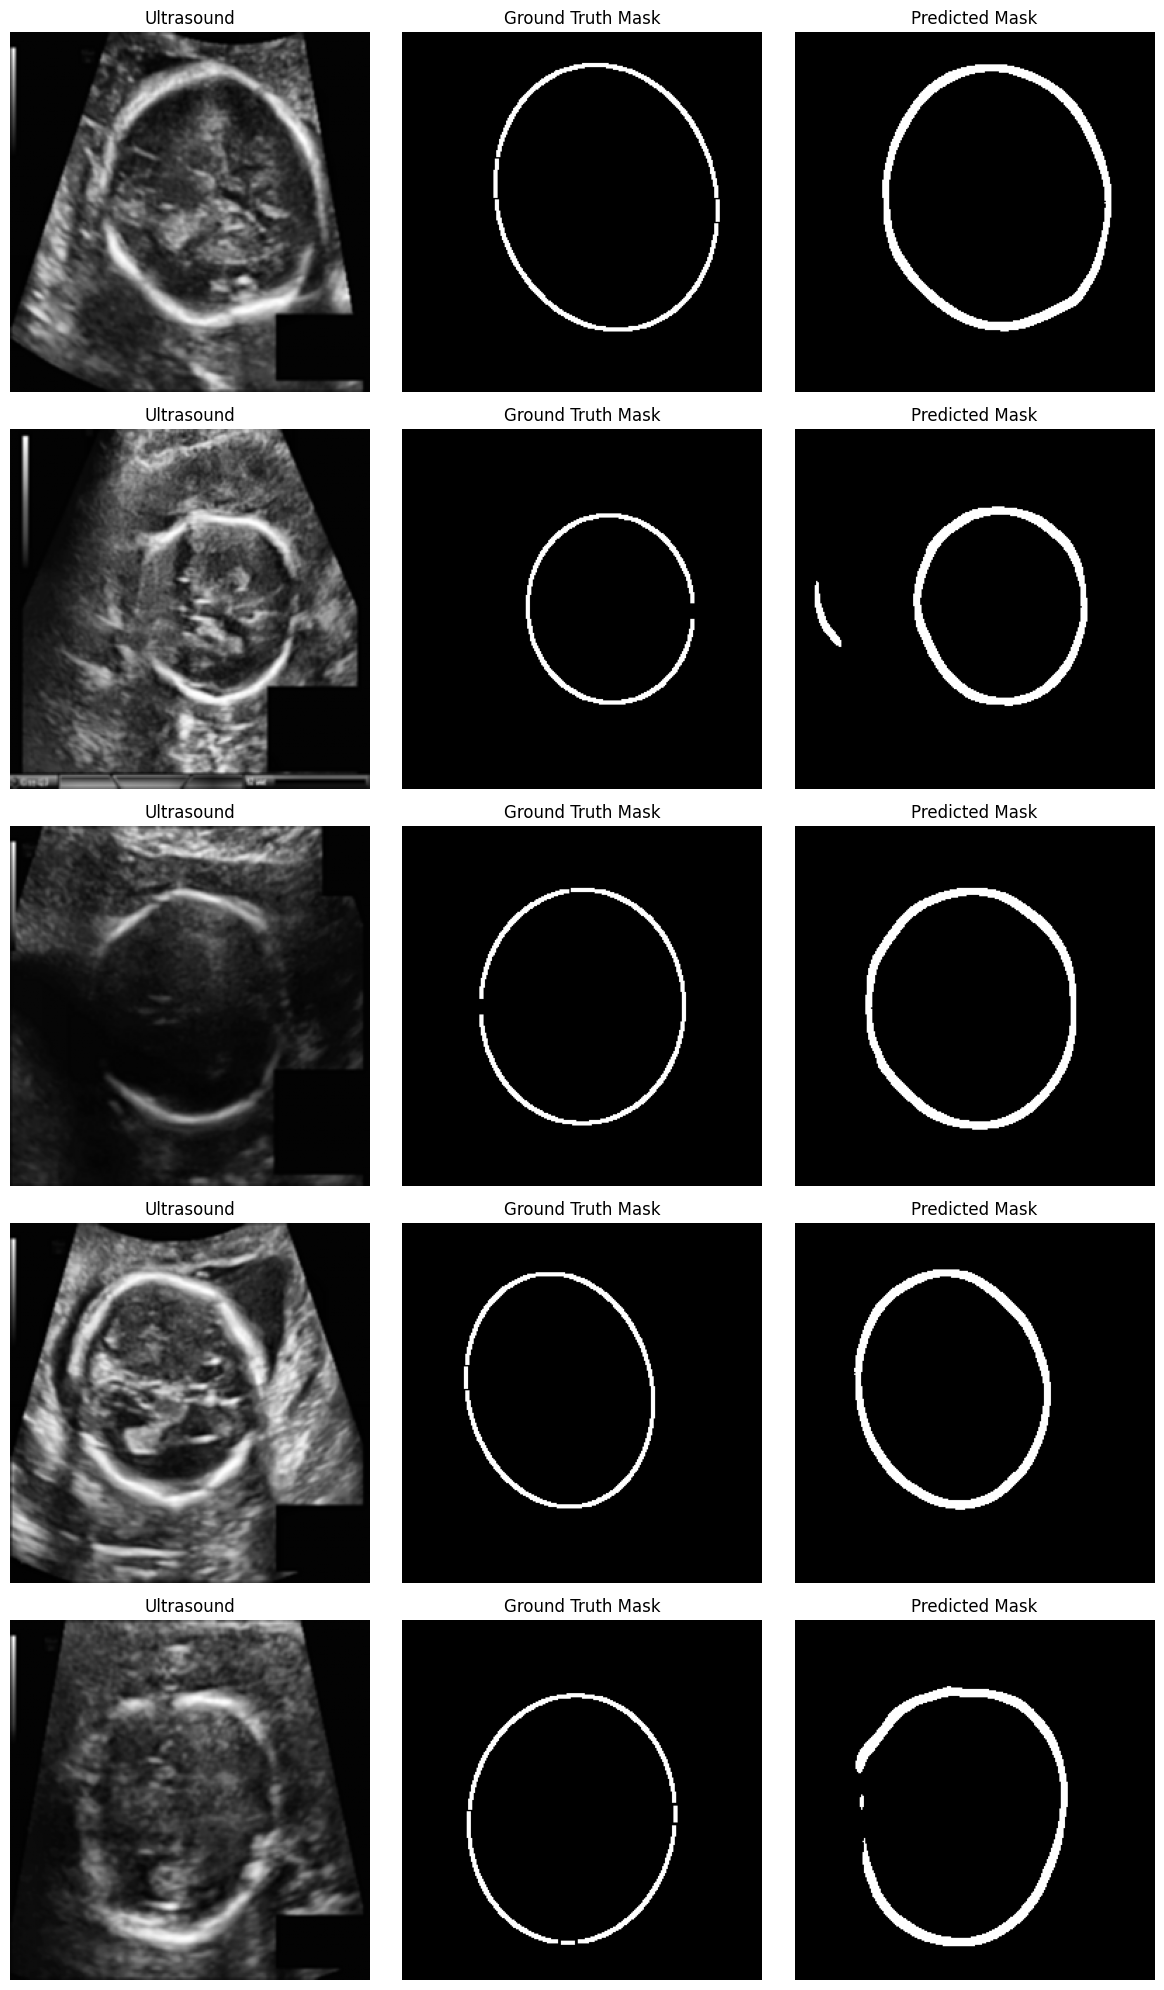

In [20]:
def visualize_predictions(model, X_test, y_test, num_samples=5):
    import random
    import numpy as np
    import matplotlib.pyplot as plt

    idxs = random.sample(range(len(X_test)), num_samples)
    preds = model.predict(X_test)

    plt.figure(figsize=(12, 4*num_samples))

    for i, idx in enumerate(idxs):
        img = X_test[idx].squeeze()
        gt  = y_test[idx].squeeze()
        pr  = (preds[idx].squeeze() > 0.5).astype(np.uint8)

        # Image
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img, cmap="gray")
        plt.title("Ultrasound")
        plt.axis("off")

        # Ground Truth
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(gt, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Prediction
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pr, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_predictions(model, X_test, y_test, num_samples=5)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step


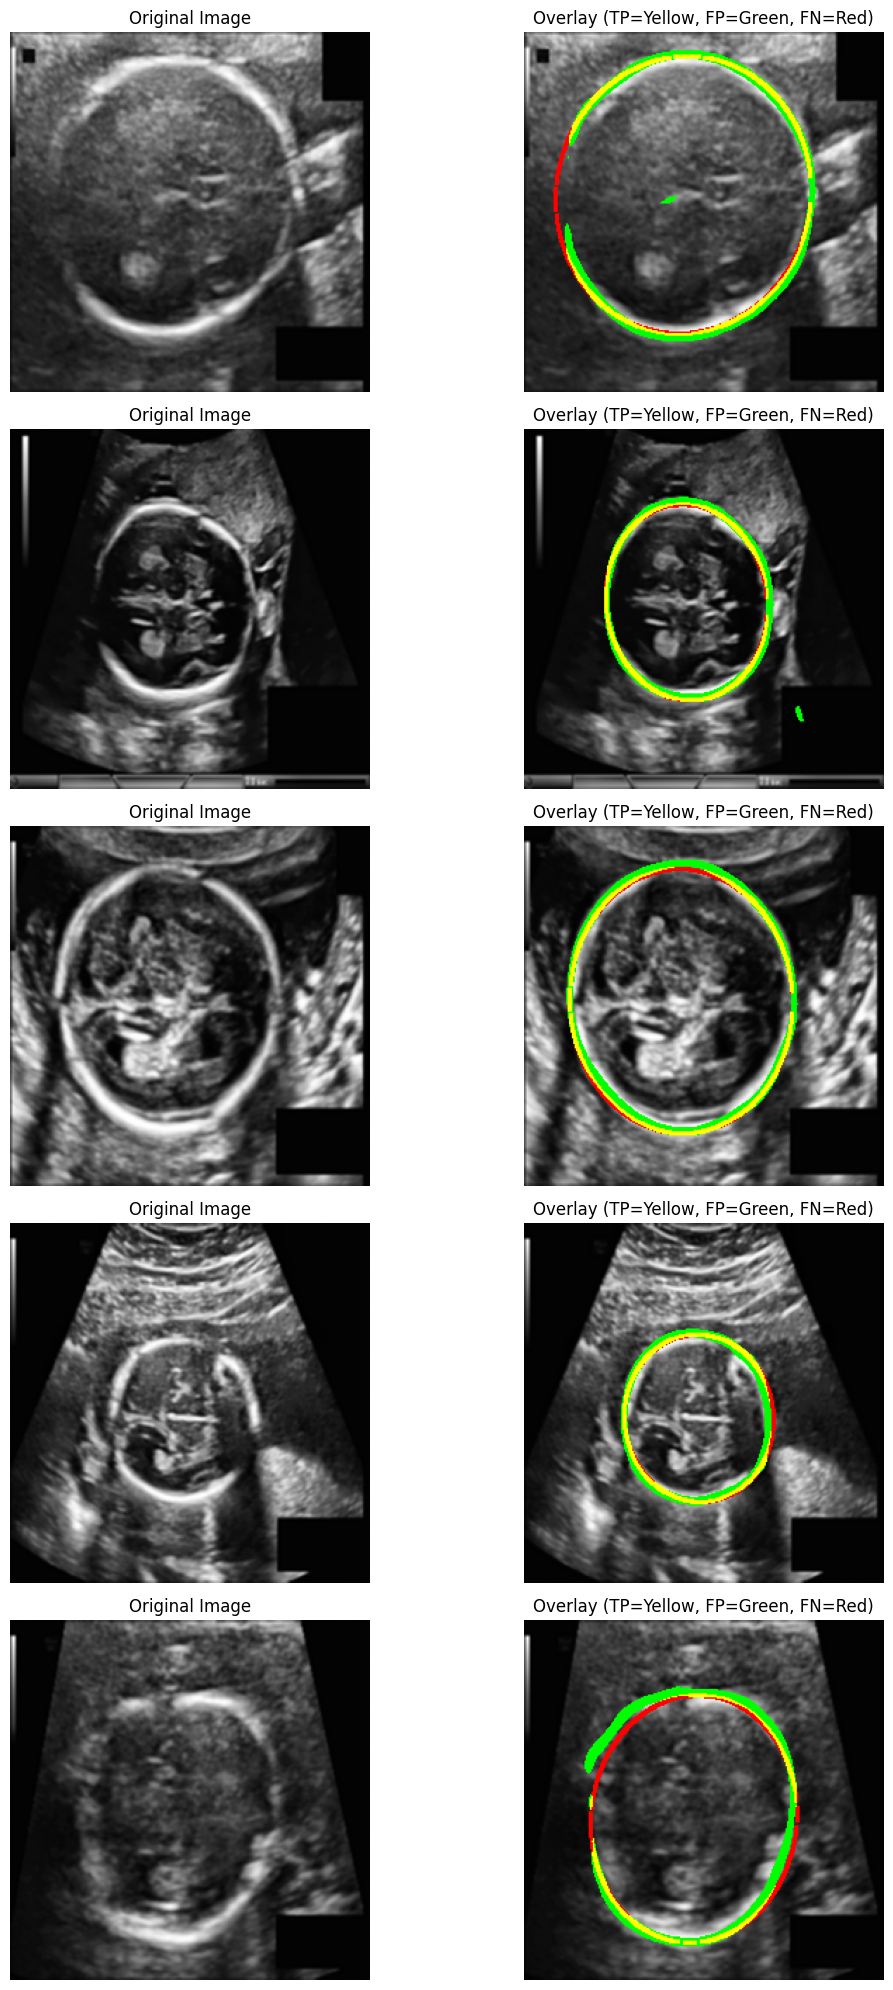

In [21]:
def visualize_overlay_comparison(model, X_test, y_test, num_samples=5):
    import random
    import numpy as np
    import matplotlib.pyplot as plt

    idxs = random.sample(range(len(X_test)), num_samples)
    preds = model.predict(X_test)

    plt.figure(figsize=(12, 4*num_samples))

    for i, idx in enumerate(idxs):
        img = X_test[idx].squeeze()
        gt  = y_test[idx].squeeze().astype(np.uint8)
        pr  = (preds[idx].squeeze() > 0.5).astype(np.uint8)

        overlay = np.stack([img, img, img], axis=-1)

        # TP (yellow)
        overlay[(gt==1) & (pr==1)] = [1,1,0]
        # FP (green)
        overlay[(gt==0) & (pr==1)] = [0,1,0]
        # FN (red)
        overlay[(gt==1) & (pr==0)] = [1,0,0]

        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(img, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, i*2+2)
        plt.imshow(overlay)
        plt.title("Overlay (TP=Yellow, FP=Green, FN=Red)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_overlay_comparison(model, X_test, y_test, num_samples=5)


In [22]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2*intersection + 1e-6) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def visualize_predictions_with_dice(model, X_test, y_test, num_samples=5):
    import random
    import numpy as np
    import matplotlib.pyplot as plt

    idxs = random.sample(range(len(X_test)), num_samples)
    preds = model.predict(X_test)

    plt.figure(figsize=(12, 4*num_samples))

    for i, idx in enumerate(idxs):
        img = X_test[idx].squeeze()
        gt  = y_test[idx].squeeze()
        pr  = (preds[idx].squeeze() > 0.5).astype(np.uint8)

        d = dice_score(gt, pr)

        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(img, cmap="gray")
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, i*2+2)
        plt.imshow(pr, cmap="gray")
        plt.title(f"Prediction (Dice={d:.3f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


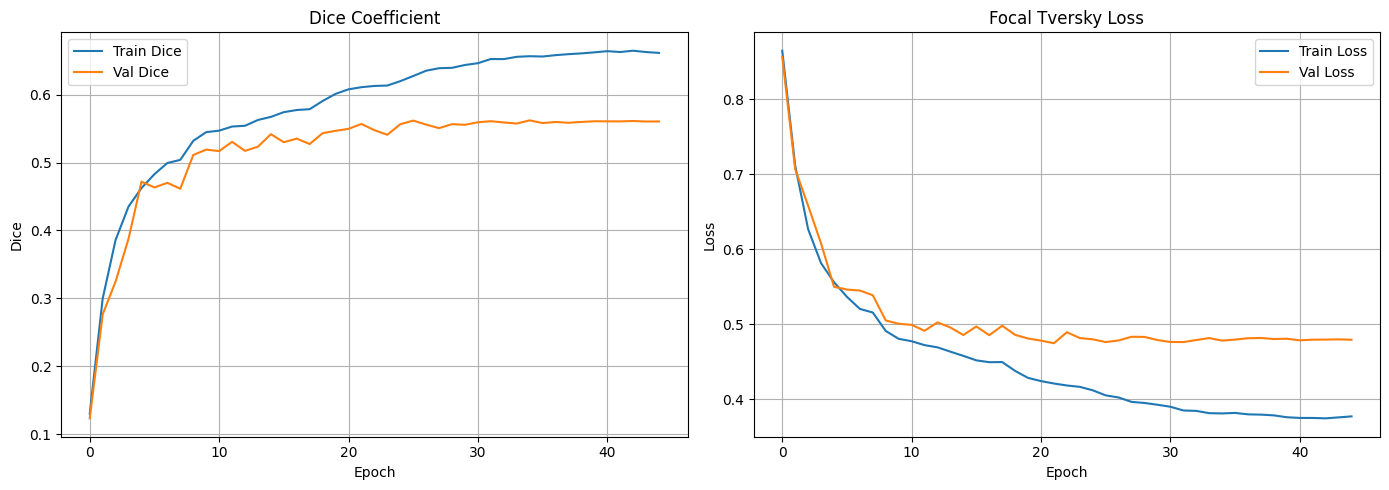

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step


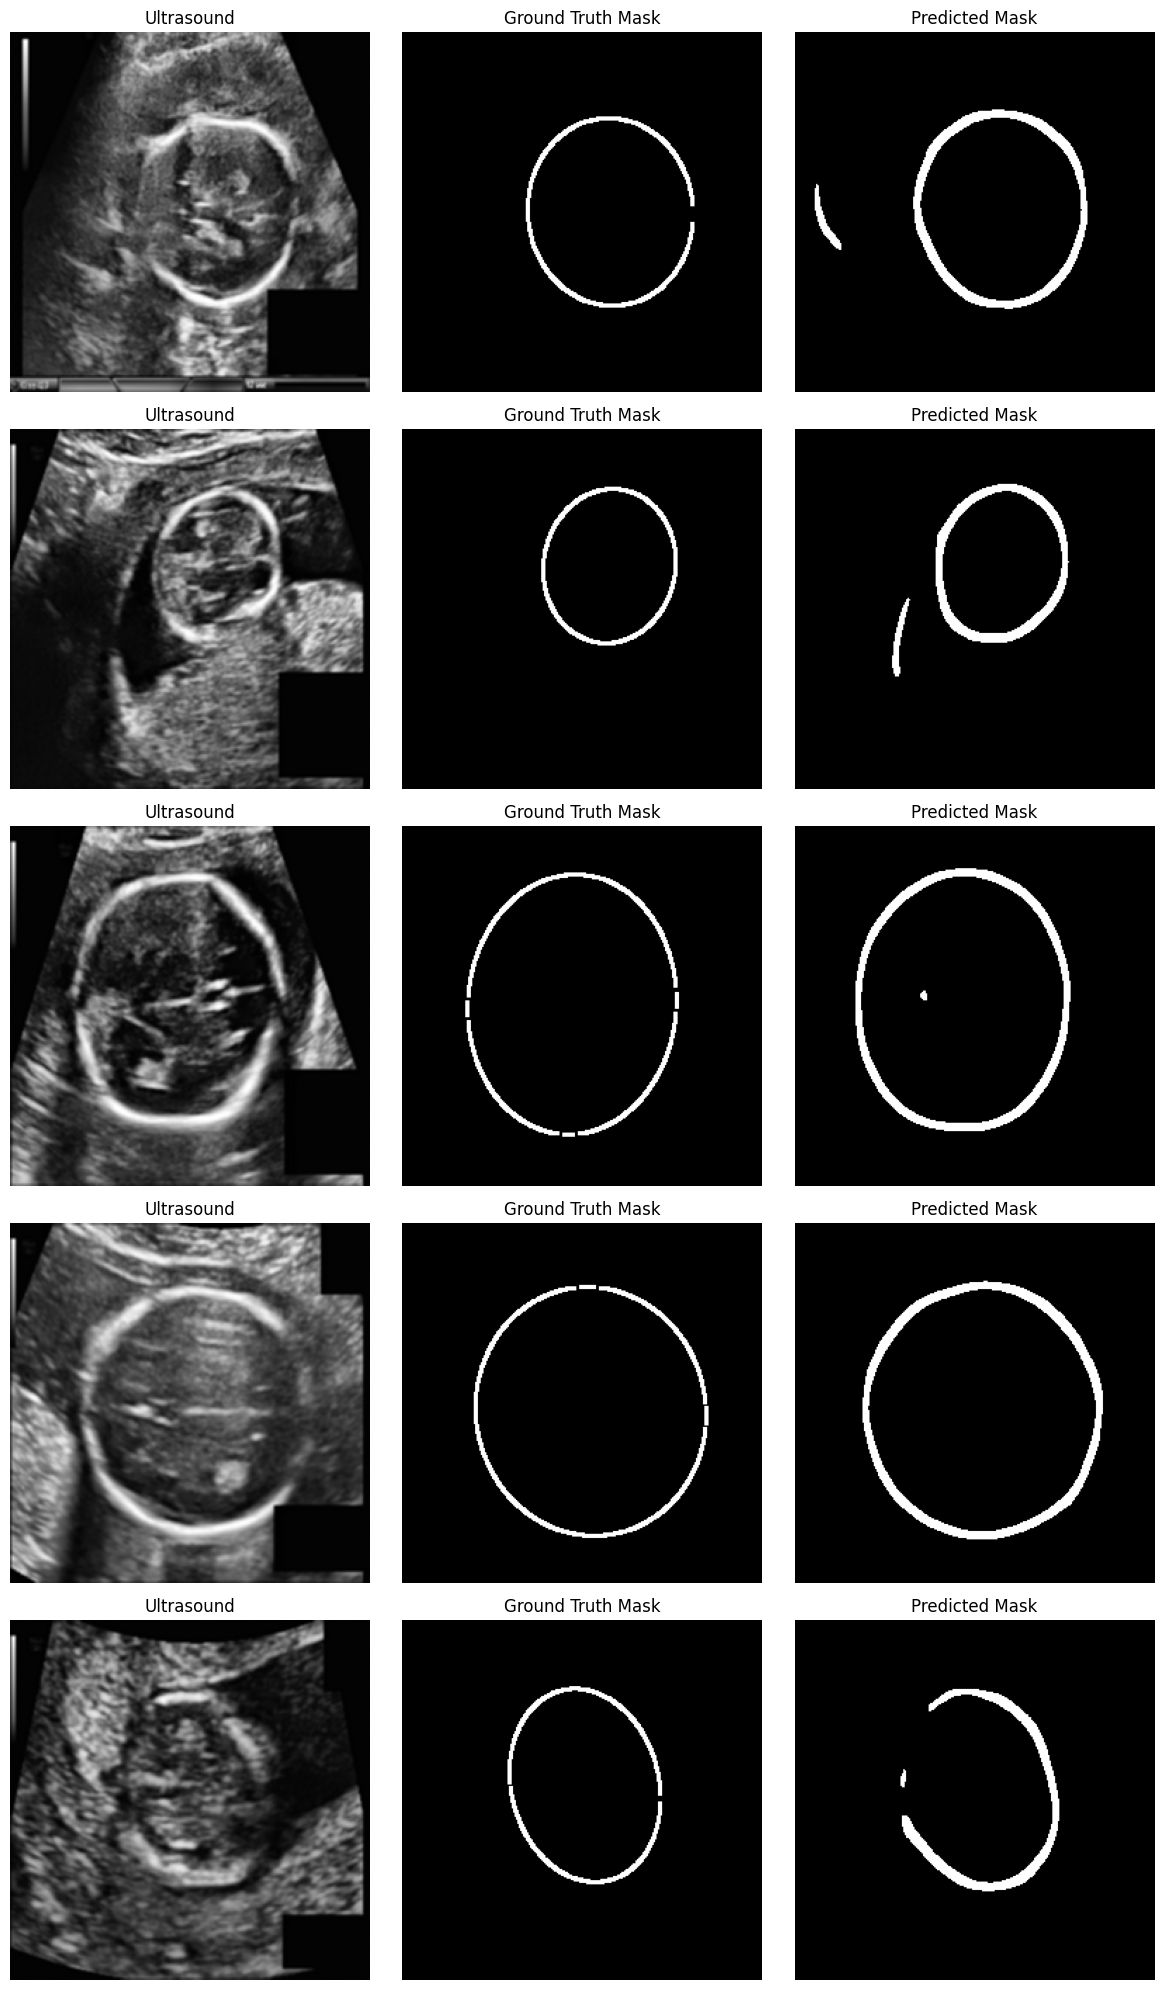

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


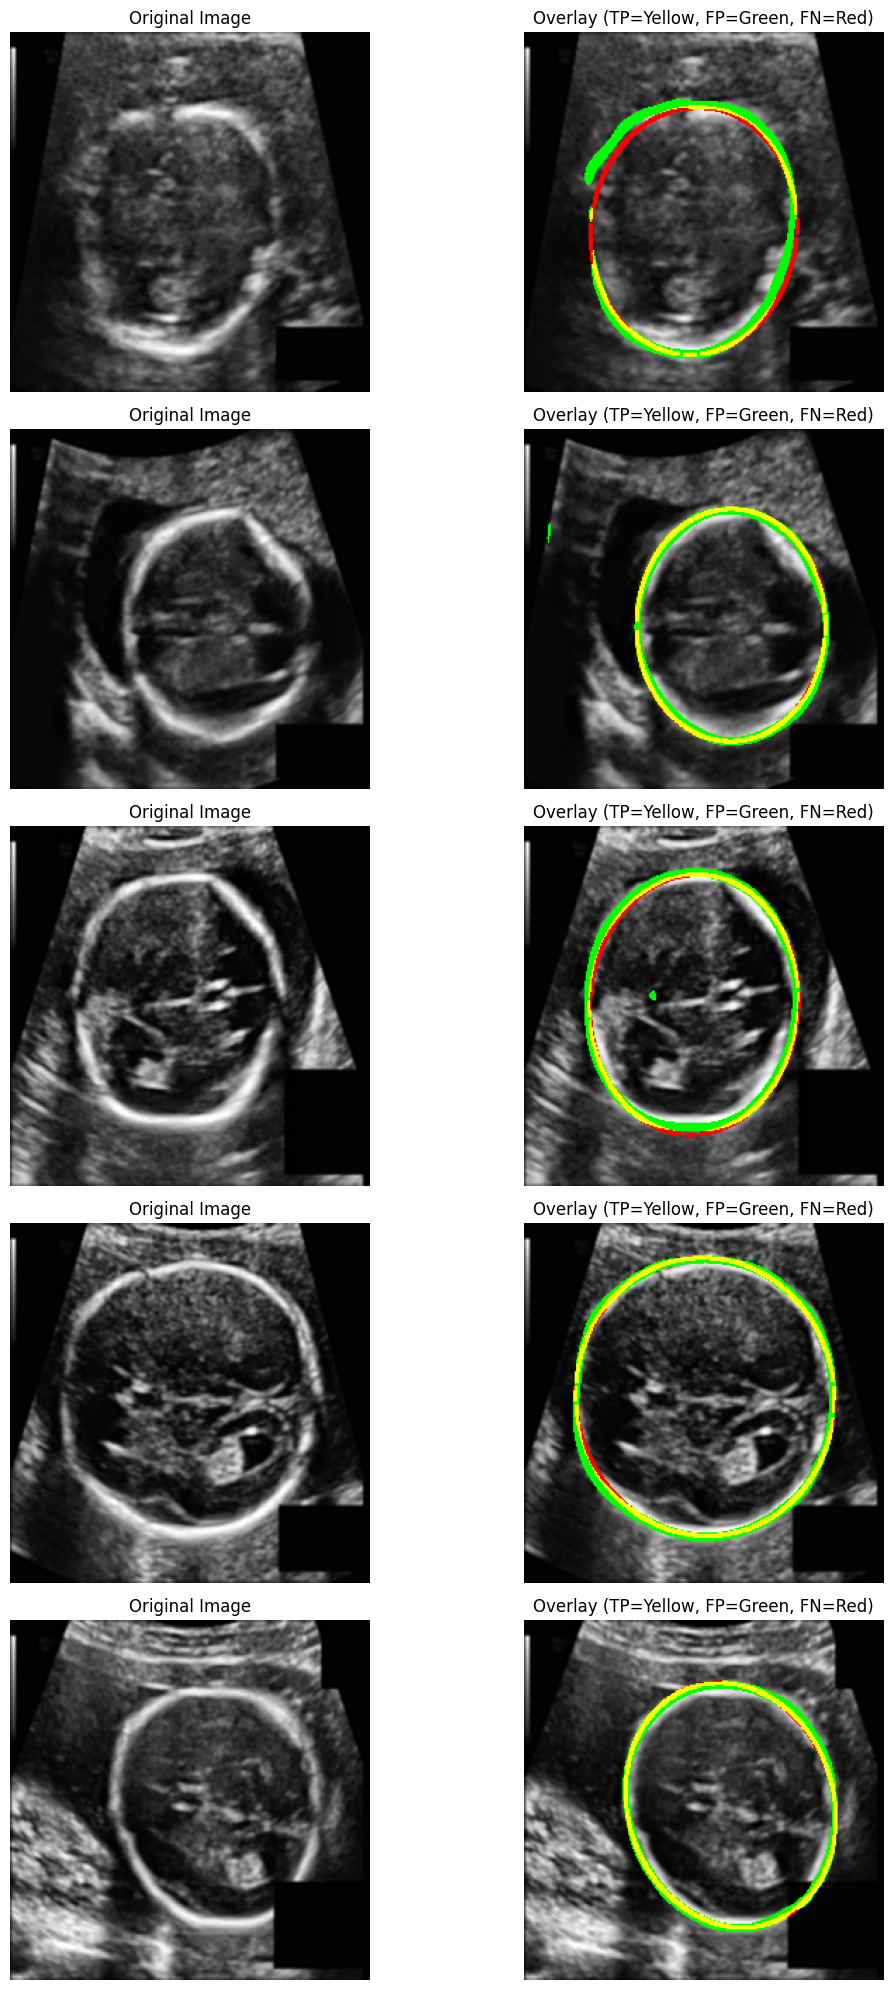

In [23]:
plot_training_history(history)
visualize_predictions(model, X_test, y_test)
visualize_overlay_comparison(model, X_test, y_test)
